# Stochastic Gradient Descent

In [169]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error 
import matplotlib as mpl

class LinearRegression:
    
    def __init__(self, learning_rate, regularization, n_epoch):
        self.learning_rate = learning_rate
        self.n_epoch = n_epoch
        self.regularization = regularization
        self.coef = np.zeros(5) #one coef for each of the terms
        self.eps = 10**-6 #used only for adagrad
        self.cache = np.zeros(self.coef.shape) #used only for adagrad
        self.mu = 0.9 #used in momentum
        self.previous_step = np.zeros(self.coef.shape) 
        
    def sgd(self, gradient):
        '''
        updates self.coef based on gradient using SGD
        '''
        self.coef = self.coef - self.learning_rate * gradient
        
    def adagrad(self, gradient):
        '''
        updates self.coef based on gradient using Adagrad
        '''
        self.cache += gradient**2
        adj_gradient = 1 / (self.eps + self.cache**(0.5))*gradient
        self.coef = self.coef - self.learning_rate * adj_gradient
        
    def sgd_momentum(self, gradient):
        '''
        updates self.coef based on gradient using Sgd_momentum
        '''
        self.coef -= self.learning_rate * gradient + self.mu * self.previous_step
        self.previous_step = self.learning_rate * gradient + self.mu * self.previous_step
        
    def fit(self, X, y, update_rule='sgd', plot=False):
        
        '''
        Fits the model for the given X, y. It uses the update rule mentioned by the parameter update_rule
        and displays a plot of the coefficients vs epochs and mse vs epochs if plot is True. 
        
        -> use get_features to get the features from X
        -> for epoch in epochs:
            iterate through all x, y.
                compute prediction using linearPredict.
                compute gradient.
                pass this gradient to the respective update rule and update the coefficients
                keep track of mse and coefficients
        -> plot if required
        
        '''
        X_features = self.get_features(X)
        num_data_points = len(X)
        num_coef = len(self.coef)
        epochs = self.n_epoch
        coefs_array = np.empty(shape=(epochs, num_coef)) # creates an empty numpy array to store coefficents for each epoch
        MSE_array = np.empty(shape=(epochs)) # creates an empty numpy array to store MSE for each epoch
        
        for epoch in range(epochs):
            for n in range(num_data_points):
                y_pred = self.linearPredict(X_features)
                residual = y_pred[n] - y[n]
                n_X_1 = X[n,0]
                n_X_2 = X[n,1]
                gradient = np.array([residual,
                    (residual*(n_X_1)+self.regularization*self.coef[1]),
                    (residual*(n_X_1)*(n_X_2)+self.regularization*self.coef[2]),
                    (residual*(n_X_1**2)*(n_X_2**2)+self.regularization*self.coef[3]),
                    (residual*(n_X_2**3)+self.regularization*self.coef[4])
                ])
                if update_rule == 'sgd':
                    self.sgd(gradient)
                elif update_rule == 'sgd_momentum':
                    self.sgd_momentum(gradient)
                else:
                    self.adagrad(gradient) 
            MSE_array[epoch] = mean_squared_error(self.linearPredict(X_features),y) # store MSE
            coefs_array[epoch] = self.coef # store coefficients 
        MSE_at_end_epoch = MSE_array[-1]
        print ('The MSE at Epoch {} is {:.5f}' .format (epochs,MSE_at_end_epoch))
            
        if plot == True:
            mpl.style.use("fivethirtyeight")
            plt.figure(figsize=(16,20))
            plt.subplot(221)
            plt.plot(range(1, epochs+1), coefs_array)
            plt.xlabel('Number of Epochs')
            plt.ylabel('Coefficients')
            plt.legend(['w0', 'w1', 'w2', 'w3', 'w4'], loc='best')
            plt.subplot(222)
            plt.plot(range(1, epochs+1), MSE_array)
            plt.xlabel('Number of Epochs')
            plt.ylabel('Mean Squared Error')
            if update_rule == 'sgd':
                plt.title("MSE Using Stochastic Gradient Descent")
            elif update_rule == 'sgd_momentum':
                plt.title("MSE Using Stochastic Gradient Descent With Momentum")
            else:
                plt.title("MSE Using Adagrad")
            plt.show()
            print ('The MSE at Epoch {} is {}' .format (epochs,MSE_at_end_epoch))
        
        return (epochs,MSE_at_end_epoch)
                
    def get_features(self, X):
        '''
        X (input) is the nx2 dimensional array - n data points with X_1 and X_2.
        It returns a nX5 dimensional array - n data points with 1, X_1, X_1X_2, X_1^2X_2^2, X_2^3.
        '''
        num_data_points = len(X)
        X_1 = X[:,0]
        X_2 = X[:,1]
        return np.array([np.ones(num_data_points), X_1, X_1*X_2, (X_1**2)*(X_2**2), X_2**3]).T
    
    def linearPredict(self, X_features):
        '''
        returns the dot product of X and self.coef
        '''
        return np.dot(X_features, self.coef)

In [170]:
data = pd.read_csv('HW 3//q1_samples.csv')
X = np.array([data['x1'].values, data['x2'].values]).T
y = data['y'].values
n_epochs = 15
learning_rate = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
regularization = [0, 10, 100]

### Using SGD


In [171]:
first_MSE = True
second_MSE = False 
min_MSE = 0
min_MSE_r = 0
min_MSE_lr = 0
next_min_MSE = 0
next_min_MSE_r = 0
next_min_MSE_lr = 0

for lr in learning_rate:
    for r in regularization:
        try:
            model = LinearRegression(lr, r, n_epochs)
            print ('Learning rate: ', lr, 'Regularization: ', r)
            fit = model.fit(X, y, update_rule='sgd', plot =False)
            MSE = fit[1]
            if (first_MSE == True):
                min_MSE = MSE
                min_MSE_r = r
                min_MSE_lr = lr
                
                first_MSE = False
                second_MSE = True
            
            elif (second_MSE == True) :
                if (MSE < min_MSE):
                    next_min_MSE = min_MSE
                    next_min_MSE_r = min_MSE_r
                    next_min_MSE_lr = min_MSE_lr
                    
                    min_MSE = MSE
                    min_MSE_r = r
                    min_MSE_lr = lr
                
                else:
                    next_min_MSE = MSE
                    next_min_MSE_r = r
                    next_min_MSE_lr = lr
                
                second_MSE = False
                
            else:
                if (MSE < min_MSE):
                    next_min_MSE = min_MSE
                    next_min_MSE_r = min_MSE_r
                    next_min_MSE_lr = min_MSE_lr
                    
                    min_MSE = MSE
                    min_MSE_r = r
                    min_MSE_lr = lr
                    
                elif (MSE < next_min_MSE):
                    next_min_MSE = MSE
                    next_min_MSE_r = r
                    next_min_MSE_lr = lr
        except:
            print ('Diverged')

Learning rate:  0.0001 Regularization:  0
The MSE at Epoch 15 is 0.03543
Learning rate:  0.0001 Regularization:  10
The MSE at Epoch 15 is 0.03967
Learning rate:  0.0001 Regularization:  100
The MSE at Epoch 15 is 0.04056
Learning rate:  0.001 Regularization:  0
The MSE at Epoch 15 is 0.02088
Learning rate:  0.001 Regularization:  10
The MSE at Epoch 15 is 0.02734
Learning rate:  0.001 Regularization:  100
The MSE at Epoch 15 is 0.03331
Learning rate:  0.01 Regularization:  0
The MSE at Epoch 15 is 0.02178
Learning rate:  0.01 Regularization:  10
The MSE at Epoch 15 is 0.03347
Learning rate:  0.01 Regularization:  100
The MSE at Epoch 15 is 0.03398
Learning rate:  0.1 Regularization:  0
The MSE at Epoch 15 is 85851417165511581093489919799161452005991735625370153399691775257204672650951999993623137519000417064576924226655007276981155993298320565588269287775606141861963407317078307817753072356682066587275181939120150455234773123072.00000
Learning rate:  0.1 Regularization:  10
The MSE at

C:\Users\12103\Anaconda3\envs\Pandas\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: overflow encountered in double_scalars
C:\Users\12103\Anaconda3\envs\Pandas\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in double_scalars
C:\Users\12103\Anaconda3\envs\Pandas\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: overflow encountered in double_scalars
C:\Users\12103\Anaconda3\envs\Pandas\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: overflow encountered in double_scalars
C:\Users\12103\Anaconda3\envs\Pandas\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in subtract
C:\Users\12103\Anaconda3\envs\Pandas\lib\site-packages\sklearn\metrics\regression.py:243: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,
C:\Users\12103\Anaconda3\envs\Pandas\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: overflow encountered in do

The Best combination has a Learning Rate of 0.001 and a Regularization of 0

Below are graphs of the coefficient and MSE each with respect to the epochs

The MSE at Epoch 15 is 0.02088


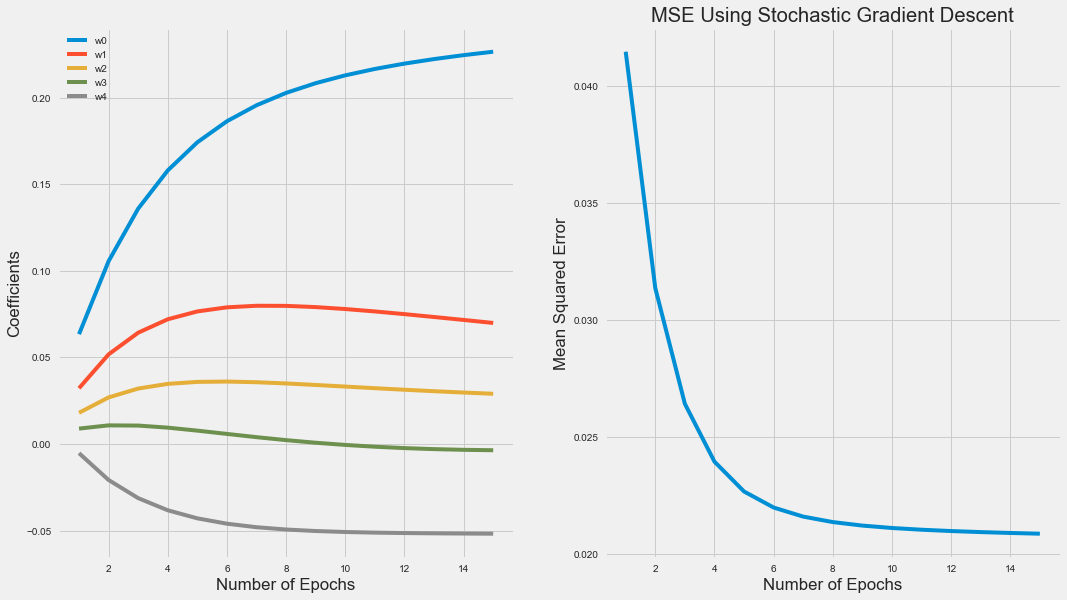

The MSE at Epoch 15 is 0.020878097917959082


(15, 0.020878097917959082)

In [172]:
# Best Combination
print ('The Best combination has a Learning Rate of {} and a Regularization of {}' .format (min_MSE_lr,min_MSE_r))
print('')
print ('Below are graphs of the coefficient and MSE each with respect to the epochs')
print('')

model = LinearRegression(min_MSE_lr, min_MSE_r, 15)
model.fit(X, y, update_rule='sgd', plot =True)

The Second Best combination has a Learning Rate of 0.01 and a Regularization of 0

Below are graphs of the coefficient and MSE each with respect to the epochs

The MSE at Epoch 15 is 0.02178


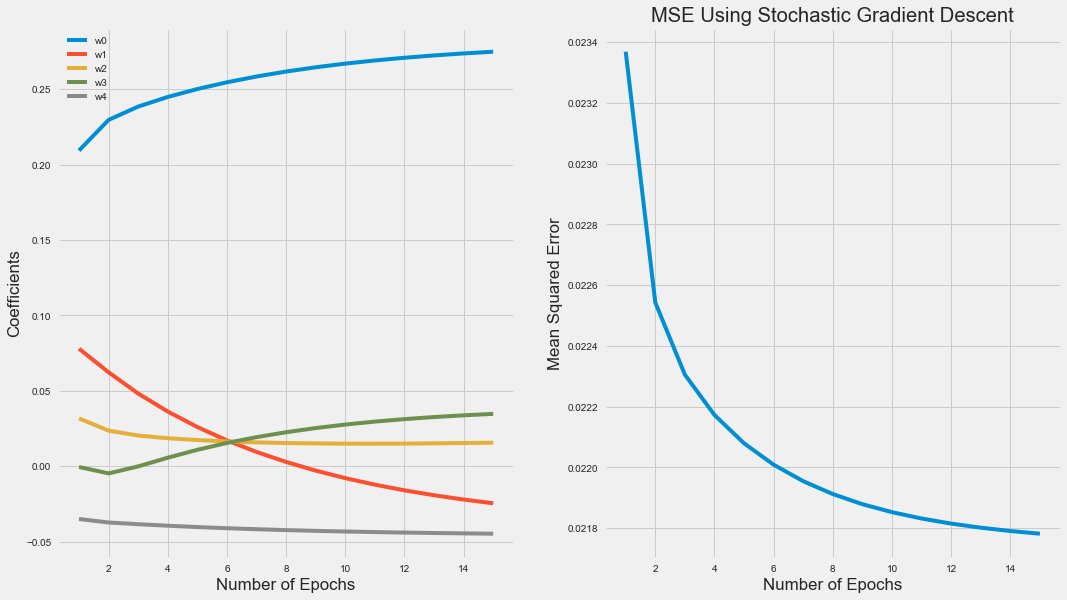

The MSE at Epoch 15 is 0.021781768945026436


(15, 0.021781768945026436)

In [173]:
# Second Best Combination
print ('The Second Best combination has a Learning Rate of {} and a Regularization of {}' .format (next_min_MSE_lr,next_min_MSE_r))
print('')
print ('Below are graphs of the coefficient and MSE each with respect to the epochs')
print('')

model = LinearRegression(next_min_MSE_lr, next_min_MSE_r, 15)
model.fit(X, y, update_rule='sgd', plot =True)

### Using SGD-Momentum

In [174]:
first_MSE = True
second_MSE = False 
min_MSE = 0
min_MSE_r = 0
min_MSE_lr = 0
next_min_MSE = 0
next_min_MSE_r = 0
next_min_MSE_lr = 0

for lr in learning_rate:
    for r in regularization:
        try:
            model = LinearRegression(lr, r, n_epochs)
            print ('Learning rate: ', lr, 'Regularization: ', r)
            fit = model.fit(X, y, update_rule='sgd_momentum', plot =False)
            MSE = fit[1]
            if (first_MSE == True):
                min_MSE = MSE
                min_MSE_r = r
                min_MSE_lr = lr
                
                first_MSE = False
                second_MSE = True
            
            elif (second_MSE == True) :
                if (MSE < min_MSE):
                    next_min_MSE = min_MSE
                    next_min_MSE_r = min_MSE_r
                    next_min_MSE_lr = min_MSE_lr
                    
                    min_MSE = MSE
                    min_MSE_r = r
                    min_MSE_lr = lr
                
                else:
                    next_min_MSE = MSE
                    next_min_MSE_r = r
                    next_min_MSE_lr = lr
                
                second_MSE = False
                
            else:
                if (MSE < min_MSE):
                    next_min_MSE = min_MSE
                    next_min_MSE_r = min_MSE_r
                    next_min_MSE_lr = min_MSE_lr
                    
                    min_MSE = MSE
                    min_MSE_r = r
                    min_MSE_lr = lr
                    
                elif (MSE < next_min_MSE):
                    next_min_MSE = MSE
                    next_min_MSE_r = r
                    next_min_MSE_lr = lr
        except:
            print ('Diverged')

Learning rate:  0.0001 Regularization:  0
The MSE at Epoch 15 is 0.02087
Learning rate:  0.0001 Regularization:  10
The MSE at Epoch 15 is 0.02701
Learning rate:  0.0001 Regularization:  100
The MSE at Epoch 15 is 0.03226
Learning rate:  0.001 Regularization:  0
The MSE at Epoch 15 is 0.02026
Learning rate:  0.001 Regularization:  10
The MSE at Epoch 15 is 0.02567
Learning rate:  0.001 Regularization:  100
The MSE at Epoch 15 is 0.03655
Learning rate:  0.01 Regularization:  0
The MSE at Epoch 15 is 0.11360
Learning rate:  0.01 Regularization:  10
The MSE at Epoch 15 is 0.08441
Learning rate:  0.01 Regularization:  100
The MSE at Epoch 15 is 0.04709
Learning rate:  0.1 Regularization:  0
Diverged
Learning rate:  0.1 Regularization:  10


C:\Users\12103\Anaconda3\envs\Pandas\lib\site-packages\sklearn\metrics\regression.py:243: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,
C:\Users\12103\Anaconda3\envs\Pandas\lib\site-packages\sklearn\metrics\regression.py:243: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,
C:\Users\12103\Anaconda3\envs\Pandas\lib\site-packages\sklearn\metrics\regression.py:243: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,
C:\Users\12103\Anaconda3\envs\Pandas\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: overflow encountered in double_scalars
C:\Users\12103\Anaconda3\envs\Pandas\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\12103\Anaconda3\envs\Pandas\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in dou

Diverged
Learning rate:  0.1 Regularization:  100
Diverged
Learning rate:  1 Regularization:  0
Diverged
Learning rate:  1 Regularization:  10
Diverged
Learning rate:  1 Regularization:  100
Diverged
Learning rate:  10 Regularization:  0
Diverged
Learning rate:  10 Regularization:  10
Diverged
Learning rate:  10 Regularization:  100
Diverged
Learning rate:  100 Regularization:  0
Diverged
Learning rate:  100 Regularization:  10
Diverged
Learning rate:  100 Regularization:  100
Diverged


C:\Users\12103\Anaconda3\envs\Pandas\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in multiply
C:\Users\12103\Anaconda3\envs\Pandas\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in multiply
C:\Users\12103\Anaconda3\envs\Pandas\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in double_scalars
C:\Users\12103\Anaconda3\envs\Pandas\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: overflow encountered in double_scalars
C:\Users\12103\Anaconda3\envs\Pandas\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: overflow encountered in double_scalars
C:\Users\12103\Anaconda3\envs\Pandas\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
C:\Users\12103\Anaconda3\envs\Pandas\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in add
C:\Users\12103\Anaconda3\envs\Pandas\lib\site-packages\ipykernel_launche

The Best combination has a Learning Rate of 0.001 and a Regularization of 0

Below are graphs of the coefficient and MSE each with respect to the epochs

The MSE at Epoch 15 is 0.02026


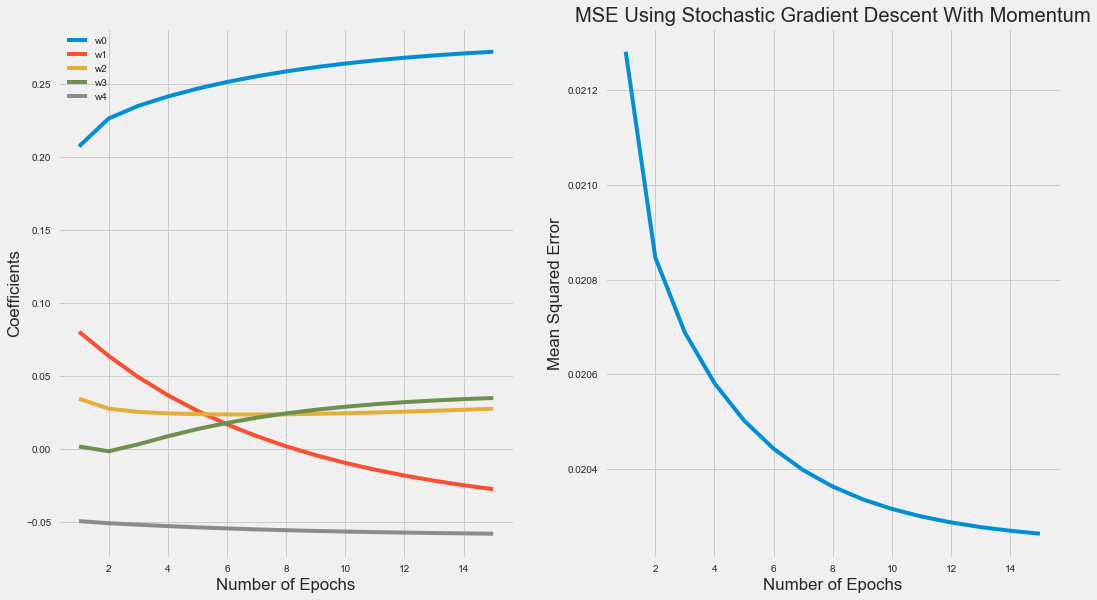

The MSE at Epoch 15 is 0.020263838535661462


(15, 0.020263838535661462)

In [175]:
# Best Combination
print ('The Best combination has a Learning Rate of {} and a Regularization of {}' .format (min_MSE_lr,min_MSE_r))
print('')
print ('Below are graphs of the coefficient and MSE each with respect to the epochs')
print('')

model = LinearRegression(min_MSE_lr, min_MSE_r, 15)
model.fit(X, y, update_rule='sgd_momentum', plot =True)

The Second Best combination has a Learning Rate of 0.0001 and a Regularization of 0

Below are graphs of the coefficient and MSE each with respect to the epochs

The MSE at Epoch 15 is 0.02087


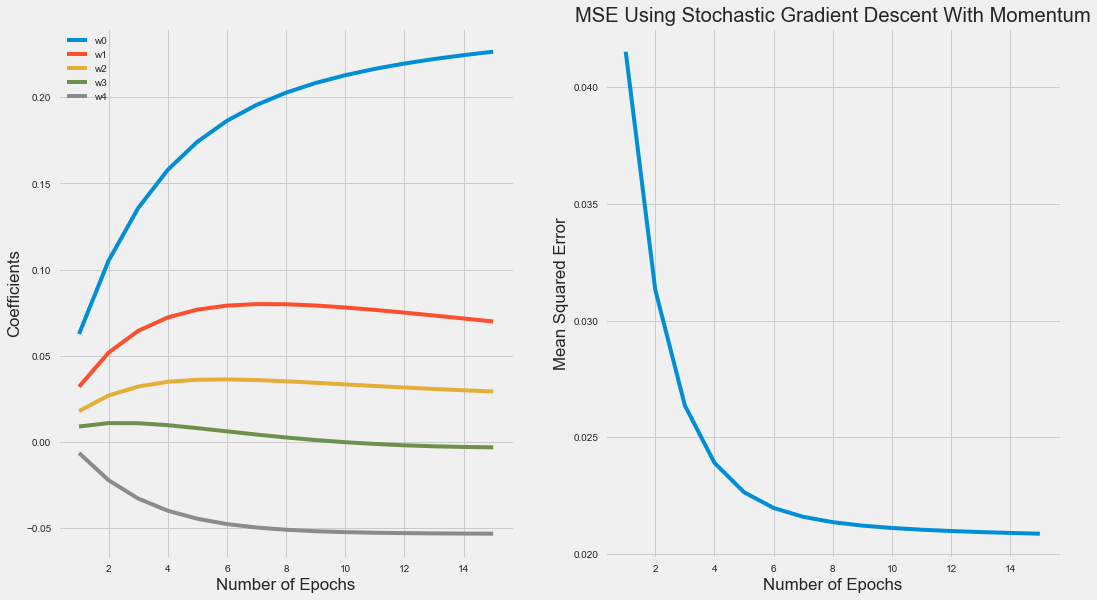

The MSE at Epoch 15 is 0.02087046249734365


(15, 0.02087046249734365)

In [176]:
# Second Best Combination
print ('The Second Best combination has a Learning Rate of {} and a Regularization of {}' .format (next_min_MSE_lr,next_min_MSE_r))
print('')
print ('Below are graphs of the coefficient and MSE each with respect to the epochs')
print('')

model = LinearRegression(next_min_MSE_lr, next_min_MSE_r, 15)
model.fit(X, y, update_rule='sgd_momentum', plot =True)

### Using Adagrad

In [177]:
first_MSE = True
second_MSE = False 
min_MSE = 0
min_MSE_r = 0
min_MSE_lr = 0
next_min_MSE = 0
next_min_MSE_r = 0
next_min_MSE_lr = 0

for lr in learning_rate:
    for r in regularization:
        try:
            model = LinearRegression(lr, r, n_epochs)
            print ('Learning rate: ', lr, 'Regularization: ', r)
            fit = model.fit(X, y, update_rule='adagrad', plot =False)
            MSE = fit[1]
            if (first_MSE == True):
                min_MSE = MSE
                min_MSE_r = r
                min_MSE_lr = lr
                
                first_MSE = False
                second_MSE = True
            
            elif (second_MSE == True) :
                if (MSE < min_MSE):
                    next_min_MSE = min_MSE
                    next_min_MSE_r = min_MSE_r
                    next_min_MSE_lr = min_MSE_lr
                    
                    min_MSE = MSE
                    min_MSE_r = r
                    min_MSE_lr = lr
                
                else:
                    next_min_MSE = MSE
                    next_min_MSE_r = r
                    next_min_MSE_lr = lr
                
                second_MSE = False
                
            else:
                if (MSE < min_MSE):
                    next_min_MSE = min_MSE
                    next_min_MSE_r = min_MSE_r
                    next_min_MSE_lr = min_MSE_lr
                    
                    min_MSE = MSE
                    min_MSE_r = r
                    min_MSE_lr = lr
                    
                elif (MSE < next_min_MSE):
                    next_min_MSE = MSE
                    next_min_MSE_r = r
                    next_min_MSE_lr = lr
        except:
            print ('Diverged')

Learning rate:  0.0001 Regularization:  0
The MSE at Epoch 15 is 0.05803
Learning rate:  0.0001 Regularization:  10
The MSE at Epoch 15 is 0.05906
Learning rate:  0.0001 Regularization:  100
The MSE at Epoch 15 is 0.06050
Learning rate:  0.001 Regularization:  0
The MSE at Epoch 15 is 0.03470
Learning rate:  0.001 Regularization:  10
The MSE at Epoch 15 is 0.03997
Learning rate:  0.001 Regularization:  100
The MSE at Epoch 15 is 0.04067
Learning rate:  0.01 Regularization:  0
The MSE at Epoch 15 is 0.02100
Learning rate:  0.01 Regularization:  10
The MSE at Epoch 15 is 0.02686
Learning rate:  0.01 Regularization:  100
The MSE at Epoch 15 is 0.03282
Learning rate:  0.1 Regularization:  0
The MSE at Epoch 15 is 0.02024
Learning rate:  0.1 Regularization:  10
The MSE at Epoch 15 is 0.02780
Learning rate:  0.1 Regularization:  100
The MSE at Epoch 15 is 0.03380
Learning rate:  1 Regularization:  0
The MSE at Epoch 15 is 0.02759
Learning rate:  1 Regularization:  10
The MSE at Epoch 15 is 0

The Best combination has a Learning Rate of 0.1 and a Regularization of 0

Below are graphs of the coefficient and MSE each with respect to the epochs

The MSE at Epoch 15 is 0.02024


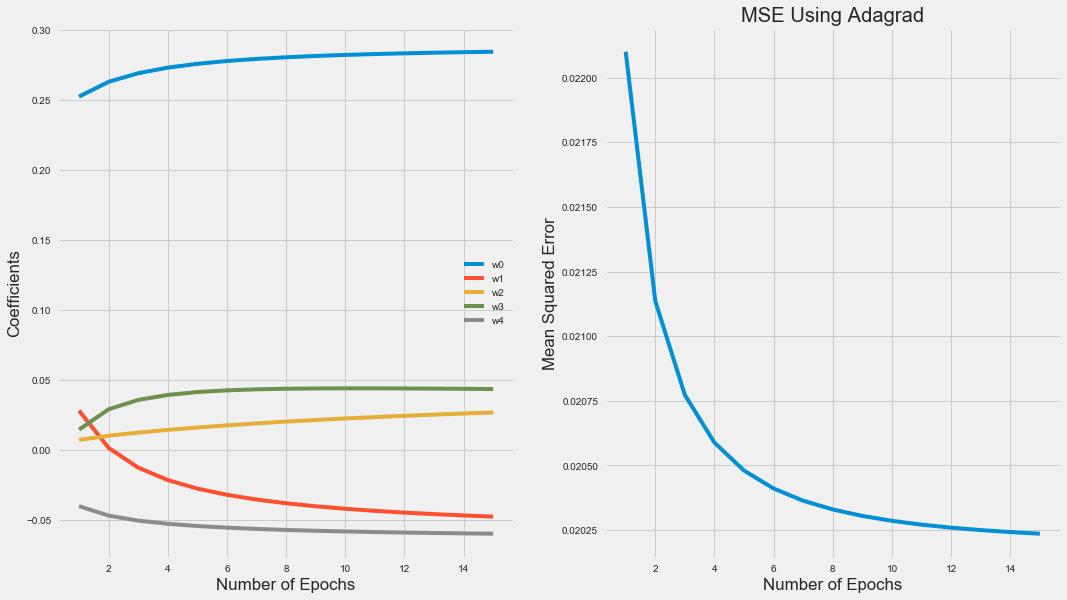

The MSE at Epoch 15 is 0.020235991507442014


(15, 0.020235991507442014)

In [178]:
# Best Combination
print ('The Best combination has a Learning Rate of {} and a Regularization of {}' .format (min_MSE_lr,min_MSE_r))
print('')
print ('Below are graphs of the coefficient and MSE each with respect to the epochs')
print('')

model = LinearRegression(min_MSE_lr, min_MSE_r, 15)
model.fit(X, y, update_rule='adagrad', plot =True)

The Second Best combination has a Learning Rate of 0.01 and a Regularization of 0

Below are graphs of the coefficient and MSE each with respect to the epochs

The MSE at Epoch 15 is 0.02100


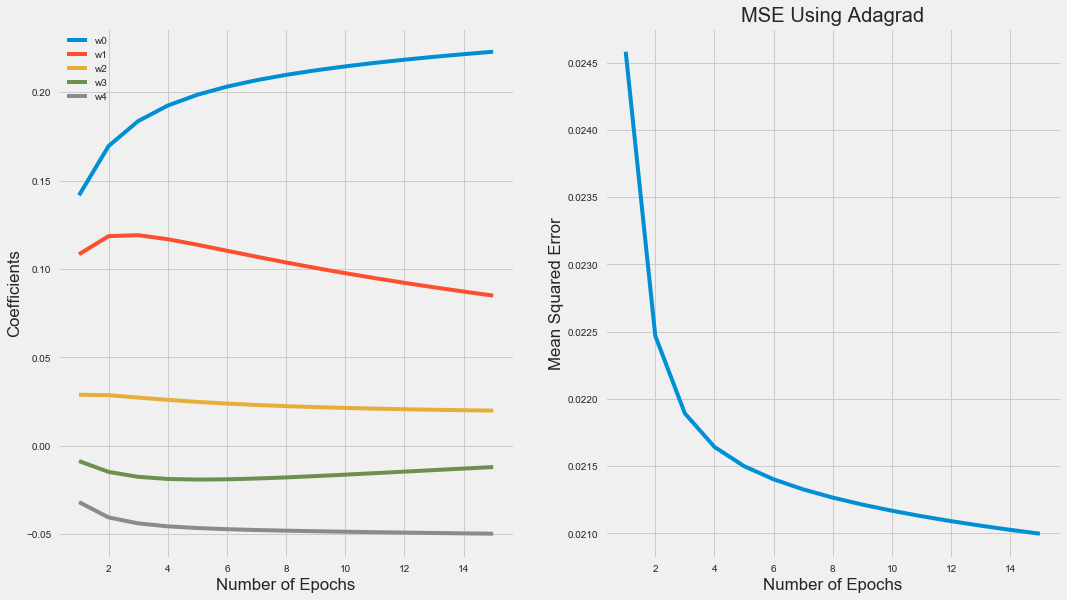

The MSE at Epoch 15 is 0.020998178850617


(15, 0.020998178850617)

In [179]:
# Second Best Combination
print ('The Second Best combination has a Learning Rate of {} and a Regularization of {}' .format (next_min_MSE_lr,next_min_MSE_r))
print('')
print ('Below are graphs of the coefficient and MSE each with respect to the epochs')
print('')

model = LinearRegression(next_min_MSE_lr, next_min_MSE_r, 15)
model.fit(X, y, update_rule='adagrad', plot =True)

## Conclusion

Adagrad allows for the largest initial learning rate. This algorithm adapts the learning rate to the coefficients and has smaller learning rates for coefficients associated with frequently occurring features. Adagrad also decreases the learning rate with each epoch. Both of these updates to the learning rate are the reason why it can have a large inital learning rate. There wasno divergence for any learning rate with adagrad and a lot of divergence for the higher learning rates when we used SGD or SGD momentum.

# Decision Trees

Using the class tree.DecisionTreeClassifier (http://scikit-learn.org/stable/modules/classes.html#module-sklearn.tree) to fit a model with default parameters.

Visualizing the tree, by saving the generated tree as a '.dot' file and using export_graphviz(https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html) and paste the contents of the file in Webgraphviz (http://www.webgraphviz.com/)


In [18]:
## read data
from sklearn.model_selection import train_test_split
from sklearn import tree
data= pd.read_csv('HW 3//q3_dataset.csv')
x = data.drop(['label'],axis=1)
y = data.label.values
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=20)

In [23]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train, y_train)
score = clf.score(x_test, y_test)
print("Test Accuracy: %.4f"
      % score)

Test Accuracy: 0.9386


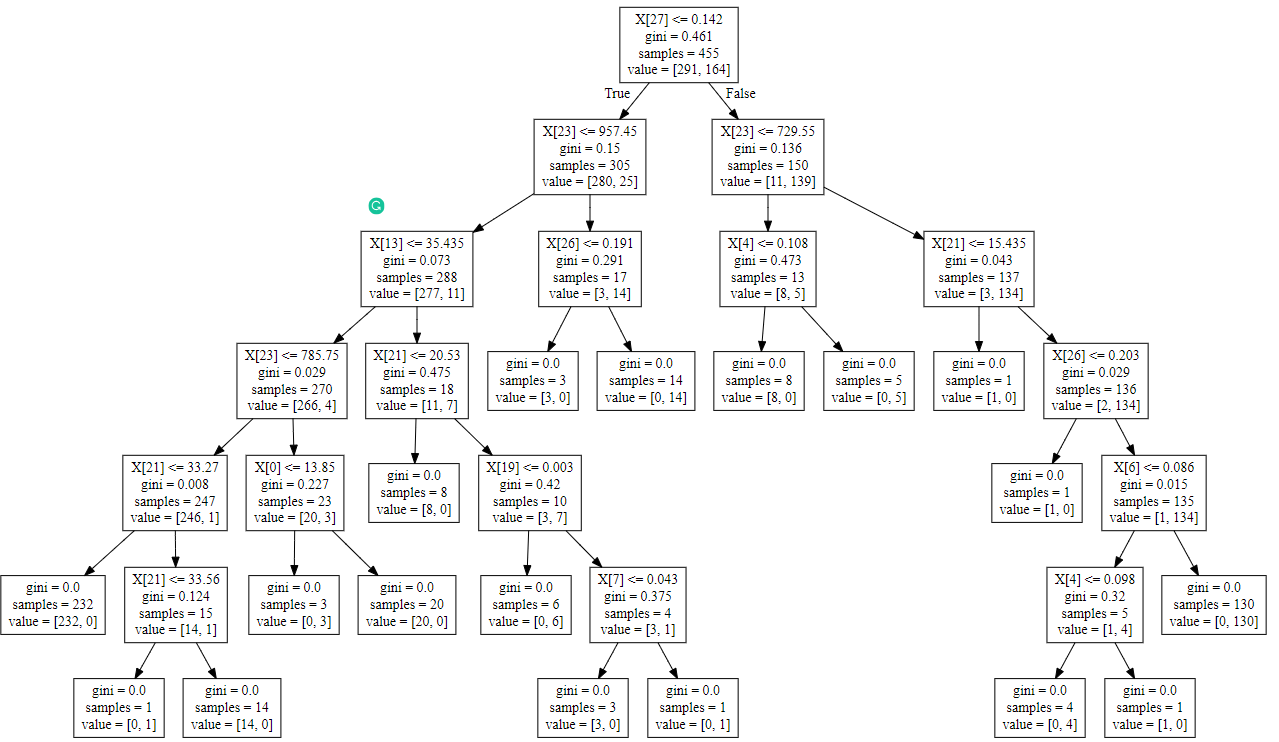

In [28]:
## save tree as .dot
with open("file_name.dot", 'w') as f:
    f = tree.export_graphviz(clf, out_file=f)
Image("q3_tree.png")

## Tune Parameters
The max_depth parameter forces the algorithm to stop after at most that many levels, the min_samples_split parameter lower bounds the amount of data required to split nodes when learning and the parameter called criterion determines what function to use to create splits at each node. 

In [59]:
max_depth_list = np.arange(20)+1
min_sample_list = 2**(np.arange(15)+1)

list_gini = []
list_entropy = []

for depth in max_depth_list:
    for sample in min_sample_list:
        clf_gini = tree.DecisionTreeClassifier(criterion = "gini", max_depth = depth, min_samples_split = sample)
        clf_gini = clf_gini.fit(x_train, y_train)
        score_gini = clf_gini.score(x_test, y_test)
        list_gini.append(tuple((depth,sample,score_gini)))
        
        clf_entropy = tree.DecisionTreeClassifier(criterion = "entropy", max_depth = depth, min_samples_split = sample)
        clf_entropy = clf_entropy.fit(x_train, y_train)
        score_entropy = clf_entropy.score(x_test, y_test)
        list_entropy.append(tuple((depth,sample,score_entropy)))   

In [74]:
from operator import itemgetter
best_depth_gini = max(list_gini, key=itemgetter(2))[0]
best_sample_gini = max(list_gini, key=itemgetter(2))[1]
best_score_gini = max(list_gini, key=itemgetter(2))[2]
print("Gini criteron with {} Max depth and {} min_samples_split Resulted in a Test Accuracy of {}" .format (best_depth_gini, best_sample_gini, best_score_gini))
best_depth_entropy = max(list_entropy, key=itemgetter(2))[0]
best_sample_entropy = max(list_entropy, key=itemgetter(2))[1]
best_score_entropy = max(list_entropy, key=itemgetter(2))[2]
print("Entropy criteron with {} Max depth and {} min_samples_split Resulted in a Test Accuracy of {}" .format (best_depth_entropy, best_sample_entropy, best_score_entropy))


Gini criteron with 2 Max depth and 256 min_samples_split Resulted in a Test Accuracy of 0.9736842105263158
Entropy criteron with 4 Max depth and 32 min_samples_split Resulted in a Test Accuracy of 0.9824561403508771


In [81]:
clf_gini = tree.DecisionTreeClassifier(criterion = "gini", max_depth = 2, min_samples_split = 256)
clf_gini = clf_gini.fit(x_train, y_train)

clf_entropy = tree.DecisionTreeClassifier(criterion = "entropy", max_depth = 4, min_samples_split = 32)
clf_entropy = clf_entropy.fit(x_train, y_train)

This is the best tree with the gini criterion


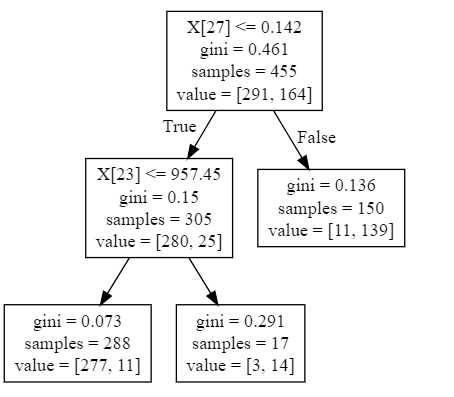

In [84]:
## save gini tree as .dot
with open("file_name.dot", 'w') as f:
    f = tree.export_graphviz(clf_gini, out_file=f)
# print gini tree
print("This is the best tree with the gini criterion")
Image("q3_gini.png")

This is the best tree with the entropy criterion


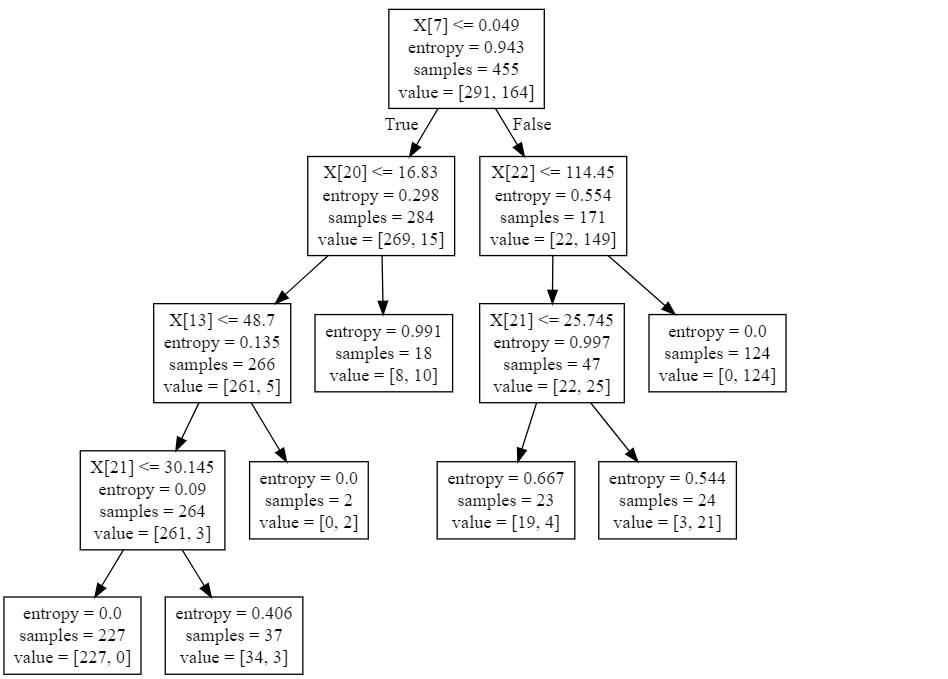

In [87]:
## save entropy tree as .dot
with open("file_name.dot", 'w') as f:
    f = tree.export_graphviz(clf_entropy, out_file=f)
# print gini tree
print("This is the best tree with the entropy criterion")
Image("q3_entropy.png")

The Tree for Gini has less leaves then the Tree that uses entropy. The leaves for entropy have a smaller number of samples on average. The leaves using entropy are reducing to 0 meaning that they have no disorder while with gini there are no leaves with perfect order.